### Environment setup 

In [1]:
# Importing neccessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras.callbacks import EarlyStopping
import os
import cv2 
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf 
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import itertools
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import time 
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# # creating a function to save images in npy formate file 
# def images_to_nuumpy_array (images,file_name,max_height,max_width):
#     resized_images = []

#     for p in images:
#         input_img = cv2.imread(str(p), cv2.IMREAD_COLOR)

#         output_img = cv2.resize(input_img,(max_height,max_width))
#         resized_images.append(input_img)

#     # Apply the ANLM filter
#     for i in range(len(resized_images)):
#         resized_images[i] = cv2.fastNlMeansDenoising(resized_images[i], None, h=10, searchWindowSize=21, templateWindowSize=7)/255
        
        

#     # Convert the list of resized images to a numpy array
#     resized_images = np.array(resized_images)
#     # Save the numpy array as a .npy file
#     np.save(f'/kaggle/working/{file_name}', resized_images)

### Image Preproccessing helper functions 

In [3]:
'''Image processing function : this function takes an array liked of image pathes 
   and resizes each image with desirale size (best practice is 256 ,512) after reading it as RGB image with 3 channels 
   then applies Non Local Mean filter with fixed parameters h=10, searchWindowSize=21, templateWindowSize=7
   then saves the output images to numpy file .npy in a desirable directory 
   parametrs:
   {
     Location_array_liked : any iterable containes locations of each image ,type:iterable liked 
     Out_location         : string contains the output directory of .npy file ,type: string 
     file_name            : string contains the output .npy file name and should end with .npy ,type : string 
     size                 : Integer refers to the width and height of the output image ,type:string 
   }
'''
def Image_preprocessing (Location_array_liked,Out_location,file_name,size=512):
    resized_images = []
    for i,path in enumerate(Location_array_liked):
                            
        input_img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        input_img=cv2.resize(input_img, (size,size))
        resized_images.append(input_img)
        resized_images[i] = cv2.fastNlMeansDenoising(resized_images[i], None, h=10, searchWindowSize=21, templateWindowSize=7)
        print(i)
    resized_images=np.array(resized_images)
    np.save(Out_location+file_name, resized_images) 
    
    
    
                            
                            


In [4]:
# creating a function to save labels in npy formate file 
def Lables_to_nuumpy_array (labels,file_name="Y_val.npy"):
  # Save the numpy array as a .npy file
  np.save(f'/kaggle/working/{file_name}', labels)

### Creating Array of paths for each images and its label 

In [5]:
# absolute path for original data 
original_data_path='/kaggle/input/dataset'

# get folders of original data 
original_data=[item for item in os.listdir(original_data_path) if item!='output']
print(original_data)

# Creating Labels dictionary according to each folder in original_data
Labels={"normal":0,"malignant":1,"benign":2}


# Creating data array to restore each image with its label 
Data=[]
for item in original_data :
    if item in Labels.keys():
        label=Labels[item]
    for image in (os.listdir(original_data_path+"/"+item)):
        i =original_data_path+'/'+item+'/'+image
        Data.append([i,label])
print(len(Data))


# get the diectory of augmented data 
augmented_path=original_data_path+'/output'
augmented_labels=os.listdir(augmented_path)
print(augmented_labels)

# append images paths to data array 
for item in augmented_labels :
    if item in Labels.keys():
        label=Labels[item]
    for image in (os.listdir(augmented_path+'/'+item)):
        if image !="(392).PNG": 
            print(augmented_path+'/'+item+'/'+image)
            i = augmented_path+'/'+item+'/'+image
            Data.append([i,label])
print(len(Data))

# covert array to numpy array 

data=np.array(Data,dtype="object")

['benign', 'normal', 'malignant']
156
['benign', 'normal', 'malignant']
/kaggle/input/dataset/output/benign/(464).PNG
/kaggle/input/dataset/output/benign/(130).PNG
/kaggle/input/dataset/output/benign/(164).PNG
/kaggle/input/dataset/output/benign/(232).PNG
/kaggle/input/dataset/output/benign/(21).PNG
/kaggle/input/dataset/output/benign/(239).PNG
/kaggle/input/dataset/output/benign/(110).PNG
/kaggle/input/dataset/output/benign/(159).PNG
/kaggle/input/dataset/output/benign/(189).PNG
/kaggle/input/dataset/output/benign/(190).PNG
/kaggle/input/dataset/output/benign/(197).PNG
/kaggle/input/dataset/output/benign/(188).PNG
/kaggle/input/dataset/output/benign/(1).PNG
/kaggle/input/dataset/output/benign/(199).PNG
/kaggle/input/dataset/output/benign/(73).PNG
/kaggle/input/dataset/output/benign/(56).PNG
/kaggle/input/dataset/output/benign/(264).PNG
/kaggle/input/dataset/output/benign/(478).PNG
/kaggle/input/dataset/output/benign/(31).PNG
/kaggle/input/dataset/output/benign/(340).PNG
/kaggle/input/

### Divide Data to Train validate and test set 

In [6]:
# split dataset into image and labels 
images  = np.array(data[:,0],dtype="object")
Labels= np.array(data[:,1])
Train_Data=pd.DataFrame(np.concatenate([images.reshape(-1,1),Labels.reshape(-1,1)],axis=1),columns=["image","Label"])


# creating train ,valdiation, test set 
train_images, test_images, train_labels, test_labels = train_test_split(images, Labels, test_size=0.2, random_state=42, stratify=Labels)
test_images, val_images, test_labels, val_labels= train_test_split(test_images, test_labels, test_size=0.5, random_state=42, stratify=test_labels)

In [7]:
# def get_max_dim (array_liked):
#     shapes=[]
#     for path in array_liked:
#         #print(path)
#         input_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#         shapes.append([input_img.shape[0],input_img.shape[1]])
#     shapes=np.array(shapes)
#     avg_aspect_ratio=(shapes[:,0]/shapes[:,1]).mean()
#     max_hight,max_width=np.max(shapes,axis=0)
#     max_hight=int(avg_aspect_ratio*max_width)
#     return max_hight,max_width

### Set Images height and width 

In [8]:
max_hight,max_width=512,512

### Plotting image from one path

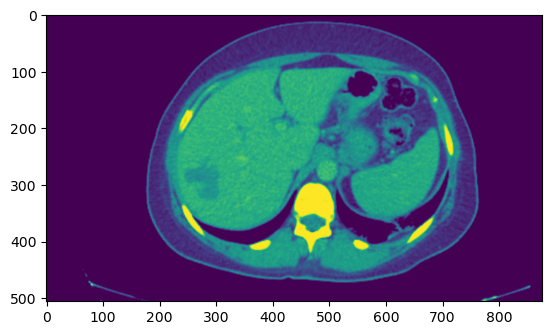

In [9]:
plt.imshow( np.array(Image.open(Train_Data["image"][1]).convert('L')))

### Preprocessing train ,validate ,test images 

In [10]:
Image_preprocessing (train_images,"/kaggle/working/","X_train.npy",size=512)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
Image_preprocessing (val_images,"/kaggle/working/","X_val.npy",size=512)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


In [12]:
Image_preprocessing (test_images,"/kaggle/working/","X_test.npy",size=512)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


In [13]:
Lables_to_nuumpy_array (train_labels,file_name="Y_train.npy")
Lables_to_nuumpy_array (val_labels,file_name="Y_val.npy")
Lables_to_nuumpy_array (test_labels,file_name="Y_test.npy")

### Loading Train,validate, Test Data

In [14]:
X_train = np.load('/kaggle/working/X_train.npy')
Y_train = np.load('/kaggle/working/Y_train.npy',allow_pickle=True)
X_val = np.load('/kaggle/working/X_val.npy')
Y_val = np.load('/kaggle/working/Y_val.npy',allow_pickle=True)
X_test = np.load('/kaggle/working/X_test.npy')
Y_test = np.load('/kaggle/working/Y_test.npy',allow_pickle=True)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(726, 512, 512, 3) (726,)
(91, 512, 512, 3) (91,)


### Encoding train and val labels

In [15]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)

In [16]:
Y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

### Loading ResNet50 Model

In [27]:
# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(max_hight, max_width, 3))

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a custom classifier on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

# Construct the full model by combining the base model and the custom classifier
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Recall()])

# Print a summary of the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 64, 64, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_block3_1_conv (Conv2D)   (None, 64, 64, 128)  65664       ['conv3_block2_out[0][0]']       
                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 64, 64, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)       

In [18]:
from keras.callbacks import Callback

class RecallStopping(Callback):
    def __init__(self, monitor='val_recall', value=0.98, verbose=0):
        super(RecallStopping, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
    
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        val_recall = logs.get(self.monitor)
        if val_recall is not None and val_recall >= self.value:
            self.model.stop_training = True
            if self.verbose > 0:
                print(f"\nReached {self.value} validation recall, stopping training...")


### Train model 

In [28]:
# Define callback to stop training if validation accuracy exceeds threshold
#callback = RecallStopping(monitor=f'val_recall_{model.name[-1]}', value=0.98, verbose=0)
start=time.time()
hist=model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=8, callbacks=callback)
end= time.time()
print(f"time taken ={end-start}")

Epoch 1/20
91/91 [==============================] - 21s 191ms/step - loss: 42.8927 - accuracy: 0.8058 - recall_1: 0.8044 - val_loss: 3.5208 - val_accuracy: 0.9231 - val_recall_1: 0.9231
Epoch 2/20
91/91 [==============================] - 17s 182ms/step - loss: 1.3178 - accuracy: 0.9780 - recall_1: 0.9780 - val_loss: 4.9718 - val_accuracy: 0.9231 - val_recall_1: 0.9231
Epoch 3/20
91/91 [==============================] - 16s 178ms/step - loss: 1.0008 - accuracy: 0.9835 - recall_1: 0.9835 - val_loss: 3.8575 - val_accuracy: 0.9560 - val_recall_1: 0.9560
Epoch 4/20
91/91 [==============================] - 16s 176ms/step - loss: 1.5226 - accuracy: 0.9821 - recall_1: 0.9821 - val_loss: 8.8318 - val_accuracy: 0.9231 - val_recall_1: 0.9231
Epoch 5/20
91/91 [==============================] - 15s 162ms/step - loss: 0.6706 - accuracy: 0.9890 - recall_1: 0.9890 - val_loss: 1.2507 - val_accuracy: 0.9890 - val_recall_1: 0.9890
Epoch 6/20
91/91 [==============================] - 16s 177ms/step - loss:

### Prpare test labels 

In [20]:
Y_test

array([2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 1, 1, 2, 1, 0, 2, 2, 0, 1, 2, 2, 2,
       1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2,
       1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 0,
       2, 2, 2], dtype=object)

In [21]:
Y_test = to_categorical(Y_test)

### Model Evaluation

In [29]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
target_names = ["normal","malignant","benign"] # replace with your class names
print(classification_report(Y_test.argmax(axis=1), y_pred_classes, target_names=target_names))



3/3 [==============================] - 2s 457ms/step
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        12
   malignant       1.00      0.95      0.97        19
      benign       0.98      1.00      0.99        60

    accuracy                           0.99        91
   macro avg       0.99      0.98      0.99        91
weighted avg       0.99      0.99      0.99        91



### Plotting confusion matrix for test Data

[[12  0  0]
 [ 0 18  1]
 [ 0  0 60]]


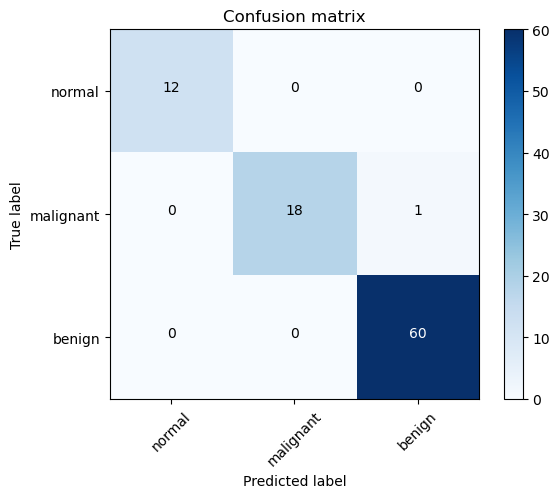

In [30]:
# Compute confusion matrix
cm = confusion_matrix(Y_test.argmax(axis=1), y_pred_classes)
print(cm)

# Plot confusion matrix with annotations
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_title('Confusion matrix')
fig.colorbar(im)
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["normal","malignant","benign"], rotation=45)
plt.yticks(tick_marks, ["normal","malignant","benign"])
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Add annotations to each cell
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

In [31]:
model.save('my_mode_opt.h5')

In [32]:
def plot_performance(history):
    plt.figure(figsize=(12,7))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')
  
    plt.ylabel('Loss')
    plt.xticks(range(0,12,1))
    #plt.yticks([i/10 for i in range(2,11)])

    
    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(0,12,1))
    #plt.yticks([i/10 for i in range(2,11)])

    plt.show()

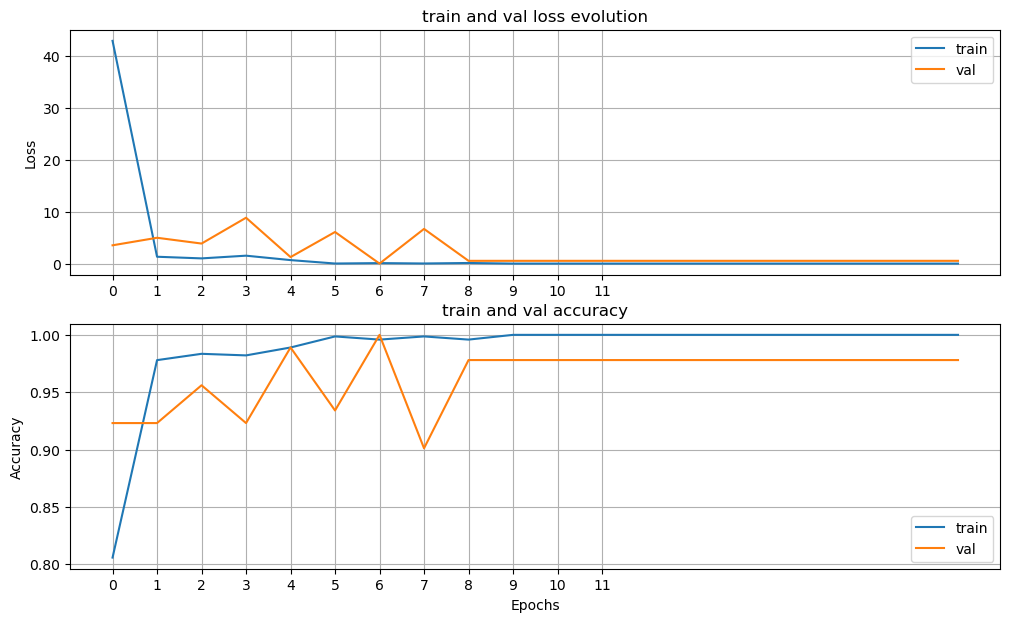

In [33]:
plot_performance(hist)

In [34]:
!conda install -y gdown

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - rapidsai/linux-64::libcuml==21.12.00=cuda11_g04c4927f3_0
  - conda-forge/linux-64::abseil-cpp==20211102.0=h93e1e8c_3
  - rapidsai/linux-64::dask-cudf==21.12.02=cuda_11_py37_g06540b9b37_0
  - conda-forge/linux-64::pyarrow==5.0.0=py37h8cf84b7_35_cuda
  - rapidsai/linux-64::cuml==21.12.00=cuda11_py37_g04c4927f3_0
  - conda-forge/linux-64::grpc-cpp==1.45.2=he70e3f0_3
  - rapidsai/linux-64::libcudf==21.12.02=cuda11_g06540b9b37_0
  - conda-forge/linux-64::arrow-cpp==5.0.0=py37h846d386_35_cuda
  - rapidsai/linux-64::cudf==21.12.02=cuda_11_py37_g06540b9b37_0
  - conda-forge/noarch::parquet-cpp==1.5.1=2
  - conda-forge/linux-64::libabseil==20211102.0=cxx17_h48a1fff_3
done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-

In [35]:
!git -init 

usage: git [-v | --version] [-h | --help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | -P | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           [--super-prefix=<path>] [--config-env=<name>=<envvar>]
           <command> [<args>]

These are common Git commands used in various situations:

start a working area (see also: git help tutorial)
   clone     Clone a repository into a new directory
   init      Create an empty Git repository or reinitialize an existing one

work on the current change (see also: git help everyday)
   add       Add file contents to the index
   mv        Move or rename a file, a directory, or a symlink
   restore   Restore working tree files
   rm        Remove files from the working tree and from the index

examine the history and state (see also: git help revisions)
   bisect    Use binary search 

In [38]:
! cp /kaggle/working/my_mode_opt.h5 /kaggle/input


cp: cannot create regular file '/kaggle/input/my_mode_opt.h5': Read-only file system


In [40]:
! git init liver_seg

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /kaggle/working/liver_seg/.git/
